# Keras sentiment analysis with Elmo Embeddings

One of the recent trends in Natural Language Processing is transfer learning. Transfer learning allows NLP models to learn more from fewer examples. In this notebook, we experiment with so-called [ELMo Embeddings](https://allennlp.org/elmo), a new approach to word embeddings that relies on a large unlabelled text corpus to understand word meaning in context. ELMo Embeddings are available from [Tensorflow Hub](https://alpha.tfhub.dev/google/elmo/2).

## Preparation

Let's first install and import all the required libraries.

In [1]:
!pip install tensorflow_hub

    100% |████████████████████████████████| 61kB 2.6MB/s ta 0:00:011
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
from keras import backend

sess = tf.Session()
backend.set_session(sess)

Using TensorFlow backend.


In [4]:
elmo_model = hub.Module("https://alpha.tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://alpha.tfhub.dev/google/elmo/2'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://alpha.tfhub.dev/google/elmo/2'.
INFO:tensorflow:Initialize variable module/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/147211ae67f6cee45196ab9725932f31e8151552/variables/variables' with aggregation/scaling
INFO:tensorflow:Initialize variable module/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/147211ae67f6cee45196ab9725932f31e8151552/variables/variables' with aggregation/weights
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/147211ae67f6cee45196ab9725932f31e8151552/variables/variables' with bilm/CNN/W_cnn_0
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/147211ae67f6cee45196ab9725932f31e8151552/variables/variables' with bilm/CNN/W_cnn_1
INFO:tensorflow:Initialize varia

INFO:tensorflow:Initialize variable module/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/147211ae67f6cee45196ab9725932f31e8151552/variables/variables' with bilm/char_embed


## ELMo Embeddings

A quick example will illustrate how ELMo Embeddings work. When we pass to our model a list of sentences (either as strings or as lists of tokens), we get back a list of 1024-dimensional embeddings for every sentence. These are the ELMo embeddings of the tokens in the sentence. 

In [5]:
embeddings = elmo_model(
    ["the cat is on the mat", "dogs are in the fog"],
    signature="default",
    as_dict=True)["elmo"]

## Sentiment analysis

In this experiment, we're going to build a simple neural network for sentiment analysis. As our training and test data, we use the IMDB movie reviews that come pre-packaged with Keras. We shuffle the reviews and pad all texts to a maximum length of 500.

In [6]:
import random
import numpy as np
from keras.datasets import imdb
from keras.preprocessing import sequence

VOCABULARY_SIZE = 50000
INDEX_FROM = 3
START_INDEX = 1
OOV_INDEX = 2
EMBEDDING_DIM = 300
SEQ_LENGTH = 500

(X_train, y_train), (X_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=VOCABULARY_SIZE,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=START_INDEX,
                                                      oov_char=OOV_INDEX,
                                                      index_from=INDEX_FROM)

train = list(zip(X_train, y_train))
random.shuffle(train)
X_train, y_train = zip(*train)
y_train = np.array(y_train)

X_train = sequence.pad_sequences(X_train, maxlen=SEQ_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=SEQ_LENGTH)

17465344/17464789 [==============================] - 1s 0us/step


## Simple embeddings

For our baseline, we're going to work with standard word embeddings. These map every token to a 300-dimensional embedding, irrespective of the context in which the token occurs. We'll use the English word embeddings from Facebook Research's [MUSE project](https://github.com/facebookresearch/MUSE).

In [7]:
!wget https://s3.amazonaws.com/arrival/embeddings/wiki.multi.en.vec -O /tmp/wiki.multi.en.vec

--2018-09-30 07:08:02--  https://s3.amazonaws.com/arrival/embeddings/wiki.multi.en.vec
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.102.29
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.102.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628614720 (599M) [text/plain]
Saving to: ‘/tmp/wiki.multi.en.vec’

/tmp/wiki.multi.en. 100%[===================>] 599.49M  22.7MB/s    in 27s     

2018-09-30 07:08:29 (22.1 MB/s) - ‘/tmp/wiki.multi.en.vec’ saved [628614720/628614720]



We load these embeddings and put the ones we need in an embedding matrix, where their row indices correspond to the token indices that Keras has assigned to the tokens in the IMDB corpus.

In [8]:
import numpy as np

def load_vectors(embedding_file_path):
    print("Loading vectors from", embedding_file_path)
    embeddings = []
    word2id = {}
    with open(embedding_file_path, 'r', encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, emb = line.rstrip().split(' ', 1)
            emb = np.fromstring(emb, sep=' ')
            assert word not in word2id, 'word found twice'
            embeddings.append(emb)
            word2id[word] = len(word2id)

    embeddings = np.vstack(embeddings)
    return embeddings, word2id

embeddings_en, embedding_word2id_en = load_vectors("/tmp/wiki.multi.en.vec")

Loading vectors from /tmp/wiki.multi.en.vec


In [9]:
def create_embedding_matrix(target_word2id, embedding_word2id, embeddings, num_rows, num_columns):
    embedding_matrix = np.zeros((num_rows, num_columns))
    for word, i in target_word2id.items():
        if i >= num_rows:
            continue
        if word in embedding_word2id: 
            embedding_matrix[i] = embeddings[embedding_word2id[word]]
    return embedding_matrix

word2id_en = imdb.get_word_index()
word2id_en = {k:(v+INDEX_FROM) for k,v in word2id_en.items()}
word2id_en["<PAD>"] = 0
word2id_en["<START>"] = START_INDEX
word2id_en["<UNK>"] = OOV_INDEX

embedding_matrix_en = create_embedding_matrix(word2id_en, embedding_word2id_en, 
                                              embeddings_en, VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM)

1646592/1641221 [==============================] - 0s 0us/step


## Models

We build two models for text classification, which are identical apart from the first layer. Our basic model has a simple embedding layer, were tokens are mapped to their static embeddings. Our ELMo model has a more complex first layer, where the static embedding for each token is concatenated to the ELMo embedding for that token in the relevant context. This results in a 1,324-dimensional embedding for each token in context. In both models, this embedding layer is followed by a simple convolution with kernel size 3, a maximum pooling operation, a dense layer, and finally a final layer that predicts the sentiment of each text as a number between 0 and 1.  

In [42]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Lambda, Input
from keras.layers import Flatten, Concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam

ELMO_EMBEDDING_DIM = 1024

def ElmoEmbedding(x):
    y = elmo_model(tf.squeeze(x), signature="default", as_dict=True)["elmo"]
    return y

def create_basic_model():
    sequence = Input(shape=(500,))
    embedding = Embedding(VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM, input_length=SEQ_LENGTH, 
                              weights=[embedding_matrix_en], trainable=False)(sequence)
        
    conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(embedding)
    pool = MaxPooling1D(pool_size=SEQ_LENGTH)(conv)
    flat = Flatten()(pool)
    dense = Dense(250, activation='relu')(flat)
    prediction = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=sequence, outputs=prediction)
    optimizer = Adam(lr=0.0001, decay=1e-3)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    #print(model.summary())
    
    return model
    
    
def create_elmo_model(): 
    token_sequence = Input(shape=(1,), dtype="string", name="elmo_input")
    index_sequence = Input(shape=(SEQ_LENGTH,), name="standard_input")

    embedding1 = Lambda(ElmoEmbedding, output_shape=(SEQ_LENGTH, ELMO_EMBEDDING_DIM,))(token_sequence)
    embedding2 = Embedding(VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM, input_length=SEQ_LENGTH, 
                          weights=[embedding_matrix_en], trainable=False)(index_sequence)
    embedding = Concatenate()([embedding1, embedding2])
        
    conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(embedding)
    pool = MaxPooling1D(pool_size=SEQ_LENGTH)(conv)
    flat = Flatten()(pool)
    dense = Dense(250, activation='relu')(flat)
    prediction = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[index_sequence, token_sequence], outputs=prediction)
    optimizer = Adam(lr=0.00001, decay=1e-3)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    #print(model.summary())
    
    return model

## Training

We train both models for a maximum of 100 epochs, but we stop earlier when the validation loss hasn't improved for two epochs. We save and evaluate the model with the lowest validation loss. Although we didn't make a big effort to tune the learning rate, we did find that the ELMo model benefits from having a much smaller initial learning rate than the basic model. We use the same decay rate for both models. 

In [43]:
import math

def train_basic_model(model, X_train, y_train, X_val, y_val, X_test, y_test): 
    batch_size = 16
    earlystop = EarlyStopping(monitor='val_loss', patience=2) 
    checkpoint = ModelCheckpoint('basic_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    model.fit(X_train, y_train, validation_data=(X_val, y_val), 
              epochs=100, batch_size=batch_size, callbacks=[earlystop, checkpoint])
    model.load_weights(filepath='basic_model.hdf5')
    scores = model.evaluate(X_test, y_test, batch_size=batch_size)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    return scores[1]*100


def train_elmo_model(model, X_train, E_train, y_train, X_val, E_val, y_val, X_test, E_test, y_test): 
    batch_size = 16
    earlystop = EarlyStopping(monitor='val_loss', patience=2)        
    checkpoint = ModelCheckpoint('elmo_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    model.fit([X_train, E_train], y_train, validation_data=([X_val, E_val], y_val), 
              epochs=100, batch_size=batch_size, callbacks=[earlystop, checkpoint])
    model.load_weights(filepath='elmo_model.hdf5')
    scores = model.evaluate([X_test, E_test], y_test, batch_size=batch_size)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    return scores[1]*100

Because the ELMo model is quite slow, we chose to work with relatively small datasets. We train on just 200 training examples, validate the model on another 200 examples after each epoch, and test its final performance on 500 test examples. We repeat this process 10 times, and choose the training and validation examples randomly from the larger IMDB training set on each iteration. The ELMo model is trained, validated and tested on exactly the same examples as the basic model.  

In [45]:
elmo_accuracies = []
basic_accuracies = []

test_size = 500
validation_size = 200
training_size = 200
id2word_en = {v:k for k,v in word2id_en.items()}

for i in range(10):     
    
    train = list(zip(X_train, y_train))
    test = list(zip(X_test, y_test))
    random.shuffle(train)
    X_train, y_train = zip(*train)
    X_test, y_test = zip(*test)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
            
    train_texts = [" ".join([id2word_en[idx] for idx in seq]) for seq in X_train[:training_size]]
    test_texts = [" ".join([id2word_en[idx] for idx in seq]) for seq in X_test[:test_size]]
    val_texts = [" ".join([id2word_en[idx] for idx in seq]) for seq in X_test[test_size:test_size+validation_size]]

    E_train = np.array(train_texts)
    E_test = np.array(test_texts)
    E_val = np.array(val_texts)
        
    model_baseline = create_basic_model()
    basic_acc = train_basic_model(model_baseline, X_train[:training_size], y_train[:training_size], 
                                  X_test[test_size:test_size+validation_size],
                                  y_test[test_size:test_size+validation_size], 
                                  X_test[:test_size], y_test[:test_size])
    basic_accuracies.append(basic_acc)

    model_elmo = create_elmo_model()
    elmo_acc = train_elmo_model(model_elmo, X_train[:training_size], E_train, y_train[:training_size],
                                X_test[test_size:test_size+validation_size], 
                                E_val, y_test[test_size:test_size+validation_size], 
                                X_test[:test_size], E_test, y_test[:test_size])
    elmo_accuracies.append(elmo_acc)
        
    print(basic_accuracies)
    print(elmo_accuracies)
    
print(np.mean(basic_accuracies))
print(np.mean(elmo_accuracies))


Train on 200 samples, validate on 200 samples
Epoch 1/100
200/200 [==============================] - 14s 68ms/step - loss: 0.6963 - acc: 0.5100 - val_loss: 0.6905 - val_acc: 0.5300
Epoch 2/100
200/200 [==============================] - 0s 1ms/step - loss: 0.6863 - acc: 0.5050 - val_loss: 0.6901 - val_acc: 0.4850
Epoch 3/100
200/200 [==============================] - 0s 1ms/step - loss: 0.6654 - acc: 0.5650 - val_loss: 0.6827 - val_acc: 0.5250
Epoch 4/100
200/200 [==============================] - 0s 1ms/step - loss: 0.6248 - acc: 0.7800 - val_loss: 0.6739 - val_acc: 0.6800
Epoch 5/100
200/200 [==============================] - 0s 1ms/step - loss: 0.5689 - acc: 0.9250 - val_loss: 0.6625 - val_acc: 0.6050
Epoch 6/100
200/200 [==============================] - 0s 1ms/step - loss: 0.4656 - acc: 1.0000 - val_loss: 0.6334 - val_acc: 0.6950
Epoch 7/100
200/200 [==============================] - 0s 1ms/step - loss: 0.3338 - acc: 1.0000 - val_loss: 0.6357 - val_acc: 0.5800
Epoch 8/100
500/500 [

200/200 [==============================] - 0s 1ms/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.4814 - val_acc: 0.7750
Epoch 18/100
200/200 [==============================] - 0s 1ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.4898 - val_acc: 0.7500
Epoch 19/100
200/200 [==============================] - 0s 1ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.4761 - val_acc: 0.7800
Epoch 20/100
200/200 [==============================] - 0s 1ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.4827 - val_acc: 0.7550
Epoch 21/100
500/500 [==============================] - 0s 463us/step
Accuracy: 77.60%
Train on 200 samples, validate on 200 samples
Epoch 1/100
200/200 [==============================] - 137s 686ms/step - loss: 0.7365 - acc: 0.5700 - val_loss: 0.7008 - val_acc: 0.5450
Epoch 2/100
200/200 [==============================] - 119s 595ms/step - loss: 0.4214 - acc: 0.9000 - val_loss: 0.6105 - val_acc: 0.6400
Epoch 3/100
200/200 [==============================] - 119s 596ms/step

## Results

When we train a basic sentiment analysis model on just 200 training examples, the results are hit and miss: the accuracies on unseen texts range from just 48% to 78%. When we replace the simple embedding layer by an ELMo embedding layer, however, the model performs about 10% better on average. Its accuracies were also much more consistent, between 73% and 78%. 

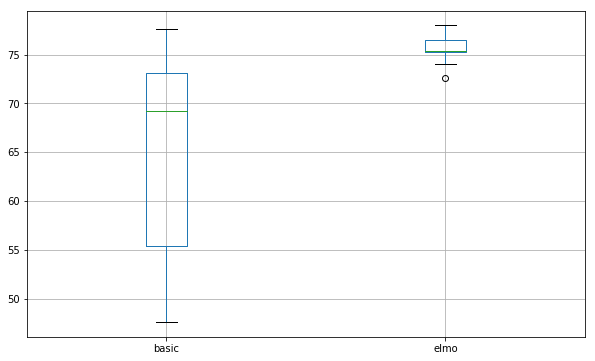

In [48]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

accuracies = pd.DataFrame({'basic' : basic_accuracies, 'elmo': elmo_accuracies})
plt.rcParams['figure.figsize'] = (10,6)
accuracies.boxplot()

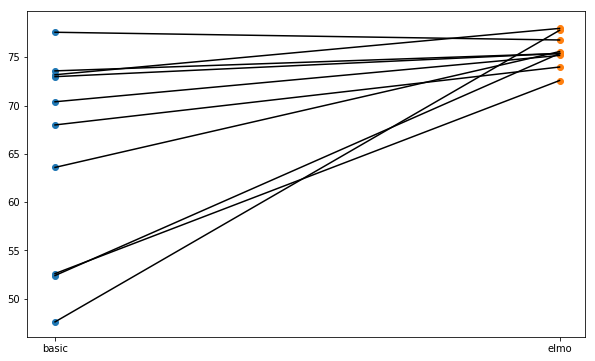

In [49]:
# Pair plot
plt.scatter(np.zeros(len(basic_accuracies)), basic_accuracies)
plt.scatter(np.ones(len(elmo_accuracies)), elmo_accuracies)

for i in range(len(basic_accuracies)):
    plt.plot( [0,1], [basic_accuracies[i], elmo_accuracies[i]], c='k')

plt.xticks([0,1], ['basic', 'elmo'])

plt.show()